In [1]:
import pandas as pd
import numpy as np
import csv
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns
import quantities as pq
from elephant.spike_train_correlation import spike_time_tiling_coefficient
import neo

In [2]:
area = 'pfdl'

In [3]:
# results_folder = 'Q:\\Personal\\Irina\\projects\\isttc\\results\\monkey\\'
results_folder = 'E:\\projects_q_30_10_2024\\isttc\\results\\monkey\\'
save_folder = results_folder + 'fixation_period_1000ms\\non_binned\\' + area + '\\acf\\'

csv_data_file_pfdl = results_folder + 'data_' + area + '_fixon_1500ms_fixation.csv'
with open(csv_data_file_pfdl, newline='') as f:
    reader = csv.reader(f)
    sua_list_pfdl = list(reader)
    
n_spike_trains_pfdl = len(sua_list_pfdl)
print('N spike_trains in {} fixON {}'.format(area, n_spike_trains_pfdl))

N spike_trains in pfdl fixON 33018


In [4]:
sua_list_pfdl[0]

['0',
 '0',
 '0',
 '20',
 '71',
 '205',
 '219',
 '247',
 '328',
 '380',
 '394',
 '428',
 '475',
 '763',
 '796',
 '1104',
 '1362',
 '1373',
 '1397',
 '1427']

In [30]:
time_series = np.asarray(sua_list_pfdl[36][3:]).astype(int)
print('time_series {}, \n shape {}'.format(time_series, time_series.shape))

time_series [  11   39  437  521  559  658  707  720  770  817  881  902  929  946
 1284 1318], 
 shape (16,)


#### Calc asf

In [50]:
def calculate_acf_sttc_t(spike_train, n_lags_, acf_lag_ms_, sttc_lag_ms_, rec_length_, verbose=True):
    shift_ms_l = np.linspace(acf_lag_ms_, acf_lag_ms_ * (n_lags_-1), n_lags_-1).astype(int)
    if verbose:
        print('shift_ms_l {}'.format(shift_ms_l))

    spike_train_bin = np.zeros(rec_length_)
    spike_train_bin[spike_train] = 1
    if verbose:
        print(spike_train_bin.shape)

    sttc_self_l = []
    # correlate with itself
    spike_train_neo = neo.SpikeTrain(spike_train, units='ms', t_start=0, t_stop=len(spike_train_bin))
    sttc_no_shift = spike_time_tiling_coefficient(spike_train_neo, spike_train_neo, dt=sttc_lag_ms_ * pq.ms)
    sttc_self_l.append(sttc_no_shift)

    # correlated shifted signal
    for shift_ms in shift_ms_l:

        spike_train_bin1 = spike_train_bin[shift_ms:]
        spike_train_bin2 = spike_train_bin[:- shift_ms]
        if verbose:
            print('spike_train_bin1 {}, spike_train_bin2 {}'.format(spike_train_bin1.shape, spike_train_bin2.shape))
        
        spike_train_bin1_idx = np.nonzero(spike_train_bin1)[0]
        spike_train_bin2_idx = np.nonzero(spike_train_bin2)[0]
        if verbose:
            print('spike_train_bin1_idx {}'.format(spike_train_bin1_idx))
            print('spike_train_bin2_idx {}'.format(spike_train_bin2_idx))
        
        spike_train_neo_1 = neo.SpikeTrain(spike_train_bin1_idx, units='ms', t_start=0, t_stop=len(spike_train_bin1))
        spike_train_neo_2 = neo.SpikeTrain(spike_train_bin2_idx, units='ms', t_start=0, t_stop=len(spike_train_bin2))
        if verbose:
            print(spike_train_neo_1)
            print(spike_train_neo_2)
        
        sttc_self = spike_time_tiling_coefficient(spike_train_neo_1, spike_train_neo_2, dt=sttc_lag_ms_ * pq.ms)
        sttc_self_l.append(sttc_self)

    return sttc_self_l

In [ ]:
def calculate_acf_sttc_t_v2(spike_train, n_lags_, acf_lag_ms_, sttc_lag_ms_, rec_length_, verbose=True):
    shift_ms_l = np.linspace(acf_lag_ms_, acf_lag_ms_ * (n_lags_-1), n_lags_-1).astype(int)
    if verbose:
        print('shift_ms_l {}'.format(shift_ms_l))

    spike_train_bin = np.zeros(rec_length_)
    spike_train_bin[spike_train] = 1
    if verbose:
        print(spike_train_bin.shape)

    spike_train_bin_zerospad = np.zeros(1000)
    if verbose:
        print('spike_train_bin_zerospad shape {}', spike_train_bin_zerospad.shape)
    
    sttc_self_l = []
    # correlate with itself
    spike_train_neo = neo.SpikeTrain(np.hstack((spike_train_bin_zerospad, spike_train_bin, spike_train_bin_zerospad)), 
                                     units='ms', t_start=0, t_stop=len(spike_train_bin))
    sttc_no_shift = spike_time_tiling_coefficient(spike_train_neo, spike_train_neo, dt=sttc_lag_ms_ * pq.ms)
    sttc_self_l.append(sttc_no_shift)

    # correlated shifted signal
    for shift_ms in shift_ms_l:

        spike_train_bin1 = spike_train_bin[shift_ms:]
        spike_train_bin2 = spike_train_bin[:- shift_ms]
        if verbose:
            print('spike_train_bin1 {}, spike_train_bin2 {}'.format(spike_train_bin1.shape, spike_train_bin2.shape))
        
        spike_train_bin1_idx = np.nonzero(spike_train_bin1)[0]
        spike_train_bin2_idx = np.nonzero(spike_train_bin2)[0]
        if verbose:
            print('spike_train_bin1_idx {}'.format(spike_train_bin1_idx))
            print('spike_train_bin2_idx {}'.format(spike_train_bin2_idx))
        
        spike_train_neo_1 = neo.SpikeTrain(spike_train_bin1_idx, units='ms', t_start=0, t_stop=len(spike_train_bin1))
        spike_train_neo_2 = neo.SpikeTrain(spike_train_bin2_idx, units='ms', t_start=0, t_stop=len(spike_train_bin2))
        if verbose:
            print(spike_train_neo_1)
            print(spike_train_neo_2)
        
        sttc_self = spike_time_tiling_coefficient(spike_train_neo_1, spike_train_neo_2, dt=sttc_lag_ms_ * pq.ms)
        sttc_self_l.append(sttc_self)

    return sttc_self_l

In [46]:
spike_train_bin = np.zeros(5)
spike_train_bin

array([0., 0., 0., 0., 0.])

In [48]:
spike_train_bin_zerospad = np.zeros(10)
spike_train_bin_zerospad

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [49]:
np.hstack((spike_train_bin_zerospad, spike_train_bin, spike_train_bin_zerospad))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [40]:
time_series = np.asarray(sua_list_pfdl[38][3:]).astype(int)
print('time_series {}, \n shape {}'.format(time_series, time_series.shape))

time_series_1000 = time_series[time_series <= 1000]
print('time_series_1000 {}, \n shape {}'.format(time_series_1000, time_series_1000.shape))

time_series [  15   47  429  485  677  859  888  913 1014 1120 1166 1179 1305 1479], 
 shape (14,)
time_series_1000 [ 15  47 429 485 677 859 888 913], 
 shape (8,)


In [51]:
n_lags = 20
acf_lag_ms = 50
sttc_lag_ms = 25
#rec_length = 20000# 15000

sttc_self_my_10000 = calculate_acf_sttc_t(time_series_1000, n_lags, acf_lag_ms, sttc_lag_ms, rec_length_=10000, verbose=True)
sttc_self_my_20000 = calculate_acf_sttc_t(time_series_1000, n_lags, acf_lag_ms, sttc_lag_ms, rec_length_=20000, verbose=True)

sttc_self_my_5000 = calculate_acf_sttc_t(time_series_1000, n_lags, acf_lag_ms, sttc_lag_ms, rec_length_=5000, verbose=True)

sttc_self_my_2000 = calculate_acf_sttc_t(time_series_1000, n_lags, acf_lag_ms, sttc_lag_ms, rec_length_=2000, verbose=True)

sttc_self_my_1000 = calculate_acf_sttc_t(time_series_1000, n_lags, acf_lag_ms, sttc_lag_ms, rec_length_=1000, verbose=True)

shift_ms_l [ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900
 950]
(10000,)
spike_train_bin1 (9950,), spike_train_bin2 (9950,)
spike_train_bin1_idx [379 435 627 809 838 863]
spike_train_bin2_idx [ 15  47 429 485 677 859 888 913]
[379 435 627 809 838 863] ms
[ 15  47 429 485 677 859 888 913] ms
spike_train_bin1 (9900,), spike_train_bin2 (9900,)
spike_train_bin1_idx [329 385 577 759 788 813]
spike_train_bin2_idx [ 15  47 429 485 677 859 888 913]
[329 385 577 759 788 813] ms
[ 15  47 429 485 677 859 888 913] ms
spike_train_bin1 (9850,), spike_train_bin2 (9850,)
spike_train_bin1_idx [279 335 527 709 738 763]
spike_train_bin2_idx [ 15  47 429 485 677 859 888 913]
[279 335 527 709 738 763] ms
[ 15  47 429 485 677 859 888 913] ms
spike_train_bin1 (9800,), spike_train_bin2 (9800,)
spike_train_bin1_idx [229 285 477 659 688 713]
spike_train_bin2_idx [ 15  47 429 485 677 859 888 913]
[229 285 477 659 688 713] ms
[ 15  47 429 485 677 859 888 913] ms
spike_train_bin1 (9750,),

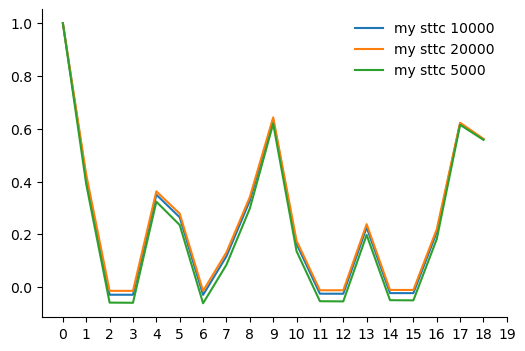

In [52]:
fig, axes = plt.subplots(1,1, figsize=(6,4))

t_lags = np.linspace(0,n_lags-1,n_lags)

axes.plot(t_lags, sttc_self_my_10000, label='my sttc 10000')
axes.plot(t_lags, sttc_self_my_20000, label='my sttc 20000')

axes.plot(t_lags, sttc_self_my_5000, label='my sttc 5000')
# axes.plot(t_lags, sttc_self_my_2000, label='my sttc 2000')

#axes.plot(t_lags, sttc_self_my_1000, label='my sttc 1000')

axes.set_xticks(t_lags)

axes.legend(frameon=False)

sns.despine()

In [28]:
t_lags

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.])